# Explore capacity for mapping song patterns to behavioral trajectory via MA code

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors
from record_0_main import smlt_ma, smlt_lnma
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

# Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

params = {'TAU_R': tau_r, 'TAU_A': tau_a, 'X_S': x_s, 'X_P': x_p}

In [5]:
# get snippets
T_SNP = 320  # min snippet length to fetch
NT_SNP = int(round(T_SNP*FPS))

snps = []
rs_ma_all = []
rs_lnma_all = []

sys.stdout.write(f'T_SNP {T_SNP}: ')

t_snp = np.arange(NT_SNP)*DT

for csng, sng_full in enumerate(sngs_full):

    segs, bds = get_seg(sng_full > 0, min_gap=NT_SNP)
    segs = [sng_full[lb:ub] for lb, ub in bds if (ub-lb >= NT_SNP)]
    snps.extend(segs)

nsnp = len(snps)

sys.stdout.write(f'{nsnp} snippets\n')

print('Lengths:')
print([f'{len(snp)*DT:.2f}' for snp in snps])

T_SNP 320: 54 snippets
Lengths:
['324.21', '376.89', '370.40', '375.46', '574.59', '1602.16', '443.79', '607.13', '733.97', '1786.58', '322.48', '420.28', '1514.05', '505.83', '1732.73', '575.29', '609.92', '542.29', '348.65', '1771.50', '340.16', '881.42', '338.99', '463.17', '1038.26', '1772.66', '734.37', '402.26', '374.36', '858.18', '705.89', '502.50', '903.50', '748.45', '1773.49', '546.92', '372.23', '589.31', '496.04', '1076.49', '1259.11', '447.89', '602.60', '434.20', '1318.58', '613.42', '677.99', '1795.74', '355.48', '931.10', '468.63', '1793.67', '468.27', '1003.20']


In [6]:
for snp in snps:
    sys.stdout.write('.')

    i_s = (snp == 1).astype(float)
    i_p = (snp == 2).astype(float)

    t_snp = np.arange(len(snp))*DT

    rs_ma = smlt_ma(i_s, i_p, params, DT)
    rs_ma_all.append(rs_ma)
    
    rs_lnma = smlt_lnma(i_s, i_p, params, DT)
    rs_lnma_all.append(rs_lnma)

......................................................

## Trained readouts (demo)

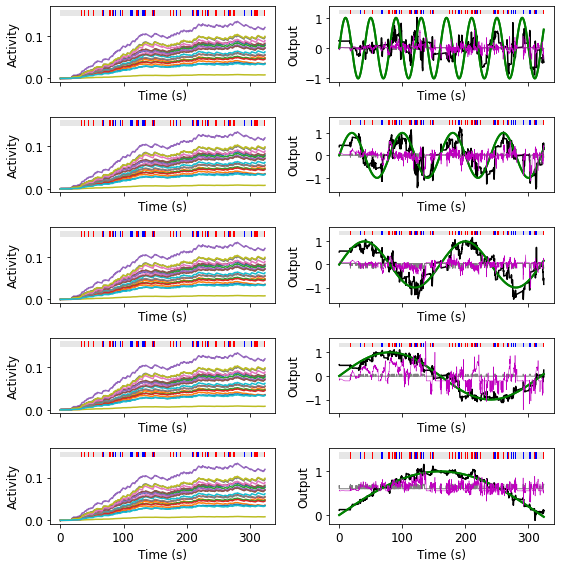

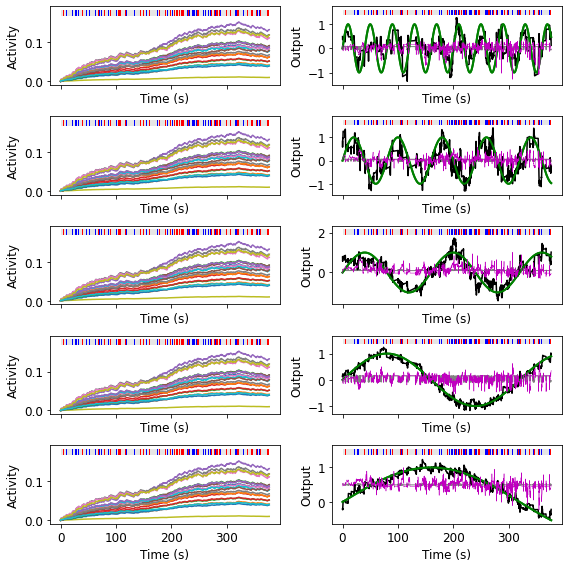

In [7]:
ALPHA = 1e-15
T_YS = [40, 80, 160, 320, 640]  # period of target sine wave (s)
TR_SAVE_PLOT = [0]

for ctr, (snp, rs_ma, rs_lnma) in enumerate(zip(snps, rs_ma_all, rs_lnma_all)):
    
    if ctr == 2:
        break

    t = np.arange(len(snp))*DT
    
    fig, axs = plt.subplots(len(T_YS), 2, figsize=(8, 1.6*len(T_YS)), tight_layout=True, sharex=True)
    
    for cy, T_Y in enumerate(T_YS):
        
        y = np.sin(2*np.pi*t/T_Y)

        axs[cy, 0].plot(t, rs_ma)
        plot_b(axs[cy, 0], t, snp, [0, t.max(), 1.1*rs_ma.max(), 1.2*rs_ma.max()], [(.9, .9, .9), 'b', 'r'])
        set_plot(axs[cy, 0], x_label='Time (s)', y_label='Activity')


        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(rs_ma, y)

        y_hat = rgr.predict(rs_ma)

        axs[cy, 1].plot(t, y, c='g', lw=2)
        axs[cy, 1].plot(t, y_hat, c='k')

        plot_b(axs[cy, 1], t, snp, [0, t.max(), 1.1*y_hat.max(), 1.25*y_hat.max()], [(.9, .9, .9), 'b', 'r'])
        

        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(rs_lnma, y)

        y_hat = rgr.predict(rs_lnma)

        axs[cy, 1].plot(t, y, c='g', lw=2)
        axs[cy, 1].plot(t, y_hat, c='m', lw=.5)


        i_s = (snp == 1)
        i_p = (snp == 2)

        x_snp = np.array([i_s, i_p]).T

        rgr_snp = linear_model.Ridge(alpha=ALPHA)
        rgr_snp.fit(x_snp, y)
        y_hat_snp = rgr_snp.predict(x_snp)

        axs[cy, 1].plot(t, y_hat_snp, c='gray', lw=1, zorder=-1)


        set_plot(axs[cy, 1], y_label='Output', font_size=12)
        set_plot(axs[cy, 1], x_label='Time (s)', font_size=12)
        
    if ctr in TR_SAVE_PLOT:
        fig.savefig(f'ms/4_res_comp_tr_{ctr}.svg')

## Stats -- error vs target frequency

In [8]:
ALPHA = 1e-15
T_YS = [5, 10, 20, 40, 80, 160, 320, 640]  # period of target sine wave (s)
T_MAX = 320

err_mas = np.nan*np.zeros((len(T_YS), len(snps)))
err_lnmas = np.nan*np.zeros((len(T_YS), len(snps)))

for ctr, (snp, rs_ma, rs_lnma) in enumerate(zip(snps, rs_ma_all, rs_lnma_all)):
    
    t = np.arange(len(snp))*DT
    
    mt = t < T_MAX
    
    for cy, T_Y in enumerate(T_YS):
        
        y = np.sin(2*np.pi*t[mt]/T_Y)

        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(rs_ma[mt, :], y)

        y_hat = rgr.predict(rs_ma[mt, :])
        
        err_mas[cy, ctr] = np.sqrt(np.mean((y-y_hat)**2))


        rgr = linear_model.Ridge(alpha=ALPHA)
        rgr.fit(rs_lnma[mt, :], y)

        y_hat = rgr.predict(rs_lnma[mt, :])
        
        err_lnmas[cy, ctr] = np.sqrt(np.mean((y-y_hat)**2))

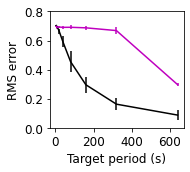

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(2.75, 2.5), tight_layout=True)
ax.errorbar(T_YS, err_mas.mean(1), yerr=err_mas.std(1), c='k')
ax.errorbar(T_YS, err_lnmas.mean(1), yerr=err_lnmas.std(1), c='m')

set_plot(ax, y_lim=(0, .8), x_label='Target period (s)', y_label='RMS error')

fig.savefig('ms/4_res_comp_ma_vs_ln_vs_period.svg')

## Stats: MA prediction of target vs period and song dur

In [10]:
ALPHA = 1e-15
T_YS = [10, 60, 600]  # period of target sine wave (s)
T_MAXS = [5, 10, 30, 60, 120]   #, 180, 240, 320]

err_mas = np.nan*np.zeros((len(T_MAXS), len(T_YS), len(snps)))

for ctr, (snp, rs_ma) in enumerate(zip(snps, rs_ma_all)):
    
    t = np.arange(len(snp))*DT
    
    for cT_MAX, T_MAX in enumerate(T_MAXS):
        mt = t < T_MAX

        for cy, T_Y in enumerate(T_YS):

            y = np.sin(2*np.pi*t[mt]/T_Y)

            rgr = linear_model.Ridge(alpha=ALPHA)
            rgr.fit(rs_ma[mt, :], y)

            y_hat = rgr.predict(rs_ma[mt, :])

            err_mas[cT_MAX, cy, ctr] = np.sqrt(np.mean((y-y_hat)**2))

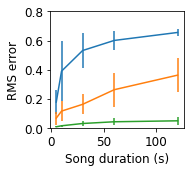

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(2.75, 2.5), tight_layout=True)
for cy, T_Y in enumerate(T_YS):
    ax.errorbar(T_MAXS, err_mas[:, cy, :].mean(1), yerr=err_mas[:, cy, :].std(1))

set_plot(ax, y_lim=(0, .8), x_label='Song duration (s)', y_label='RMS error')

fig.savefig('ms/4_res_comp_ma_vs_period_vs_song_dur.svg')